# Forest Cover Type Prediction
#### Chris, Dylan, Krista, I-Ching, Riley

In [34]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

# show all columns in DF
pd.set_option('display.max_columns', None)

## Introduction

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

In [35]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1  

In [36]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

The first step in dealing with this data will be to clean up the raw data.

In [89]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [38]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [39]:
for column in data.columns:
    print(data[column].describe(), "\n")

count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64 

count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64 

count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64 

count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64 

count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%         32.000000
75%         

In [40]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

## Helper Functions

In [41]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=42)
    return X_train, y_train, X_test, y_test

# plot two columns
def my_scatter(col_1, col_2, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(col_1, col_2, c=labels.values,
                s=50, alpha=.5, cmap='viridis')
    plt.xlabel(col_1.name)
    plt.ylabel(col_2.name)

## Exploratory Data Analysis

Let's take a look at the data that we have.

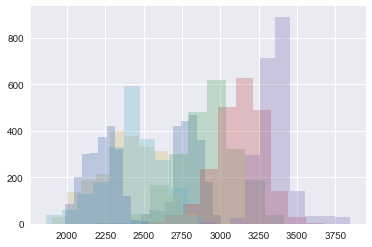

In [42]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

Elevation seems to be one of the more binnable for the cover type.  We made a note to focus on this variable.

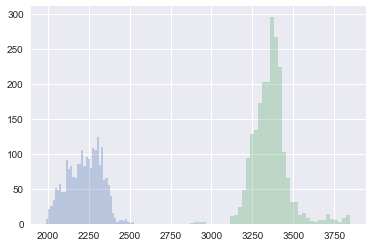

In [43]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

Types 4 and 7 are nicely separated.

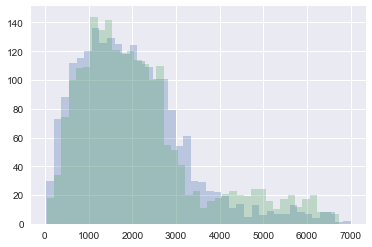

In [44]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

Types 1 and 2 have a lot of overlap on elevation. This could make them harder to predict.

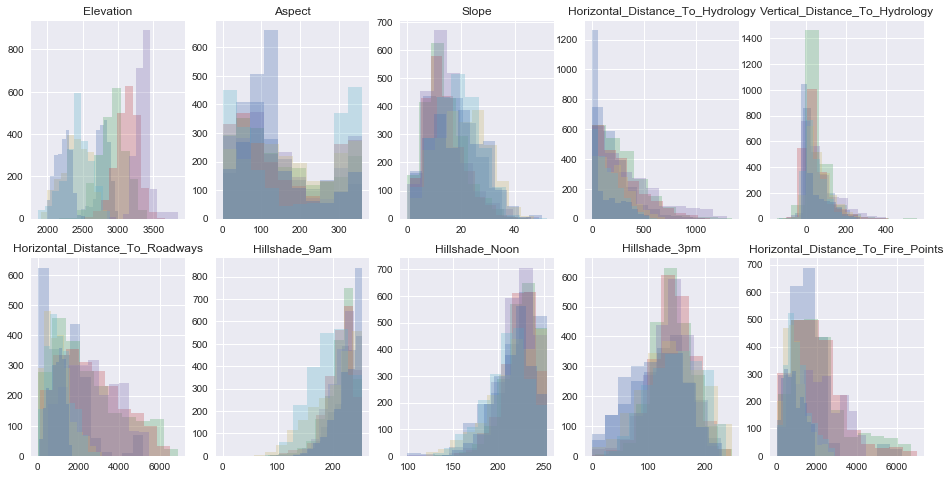

In [45]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  Many of the other variables seem to overlap quite a lot for the different cover types, which indicates that they will not be very helpful in differentiating the different cover type.  The other notable features are the Horizontal and Veritcal distances to the disturbances, which have a bit more variation.  

In [46]:
my_columns = [x for x in data.columns.tolist() if "Soil_Type" not in x]
my_columns = [x for x in my_columns if "Wilderness" not in x]
df1 = data.reindex(columns=my_columns)

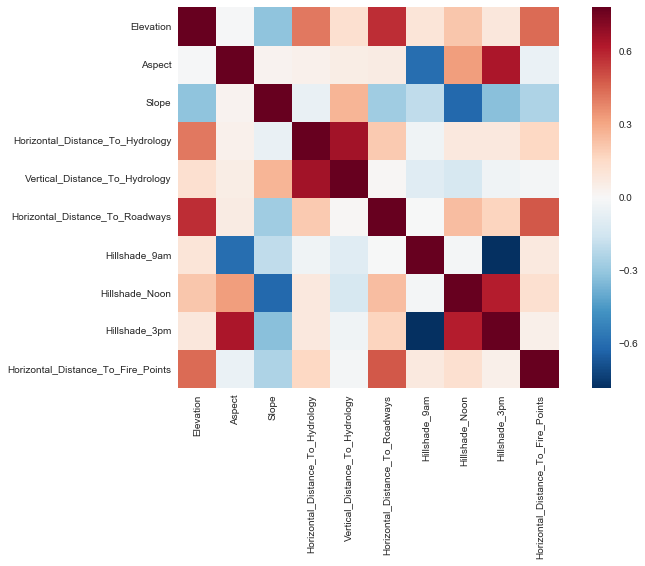

In [47]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

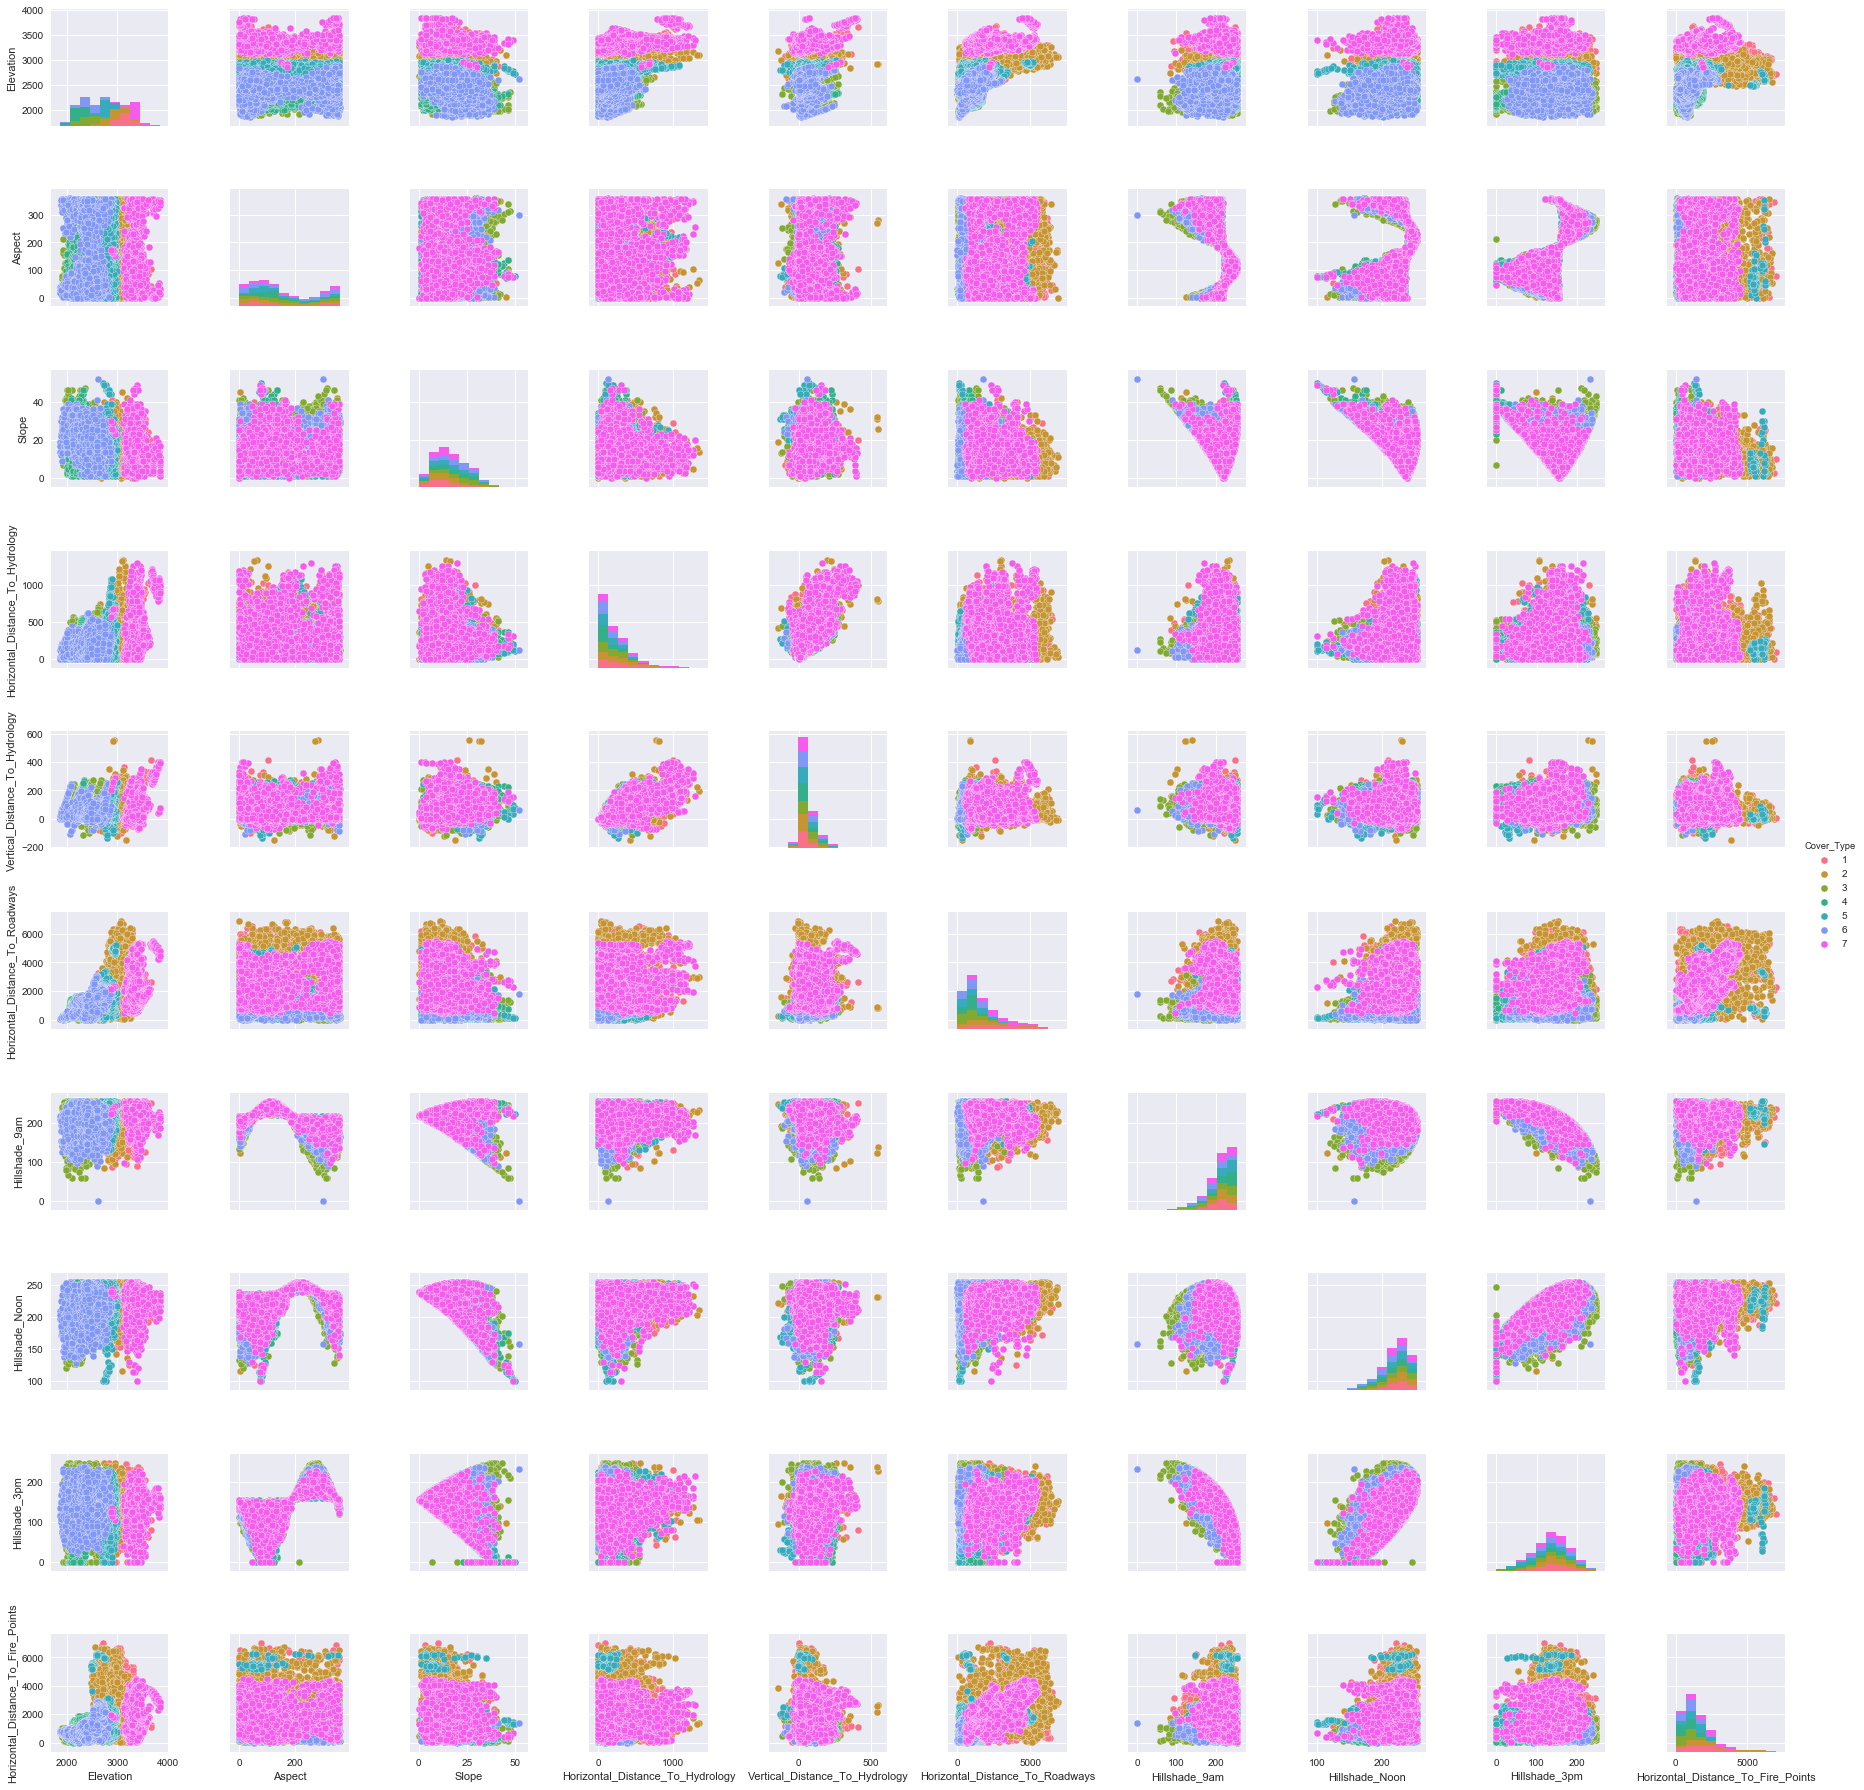

In [48]:
g = sns.pairplot(df, vars=my_columns, hue="Cover_Type")

In [49]:
# Count different soil types
data.loc[:, 'Soil_Type1':'Soil_Type40'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [50]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

Soil_Type1 355
Soil_Type2 623
Soil_Type3 962
Soil_Type4 843
Soil_Type5 165
Soil_Type6 650
Soil_Type7 0
Soil_Type8 1
Soil_Type9 10
Soil_Type10 2142
Soil_Type11 406
Soil_Type12 227
Soil_Type13 476
Soil_Type14 169
Soil_Type15 0
Soil_Type16 114
Soil_Type17 612
Soil_Type18 60
Soil_Type19 46
Soil_Type20 139
Soil_Type21 16
Soil_Type22 345
Soil_Type23 757
Soil_Type24 257
Soil_Type25 1
Soil_Type26 54
Soil_Type27 15
Soil_Type28 9
Soil_Type29 1291
Soil_Type30 725
Soil_Type31 332
Soil_Type32 690
Soil_Type33 616
Soil_Type34 22
Soil_Type35 102
Soil_Type36 10
Soil_Type37 34
Soil_Type38 728
Soil_Type39 657
Soil_Type40 459


Soil types don't seem to be very consisten, and some soil types have 0 data points, which may need to be dropped.  Overall, we may find that the soil type won't be too helpful.

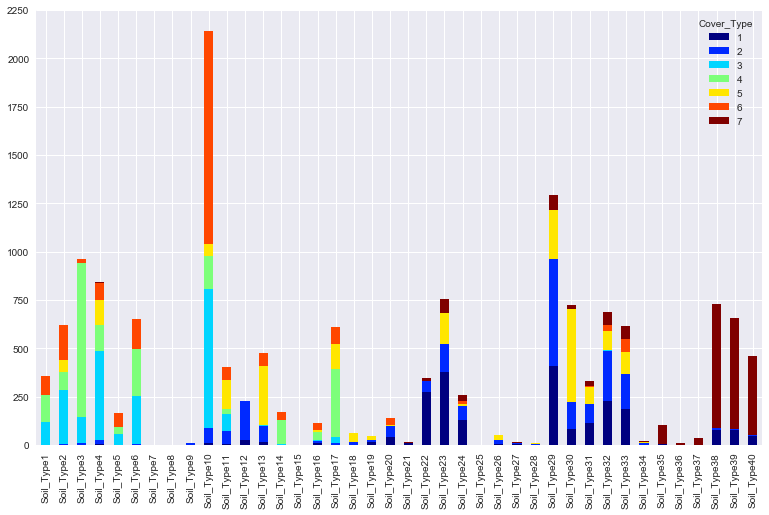

In [51]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

We can see some subtle differences when plotting the cover type that different soils have.  For example, cover type 7 seems to be heavily on the soil types 38,39,40.  In addition, cover type 6 seems to trend towards the lower soil types.  Other points seem to be a bit more scattered.

In [52]:
# Count at different wilderness areass
data.loc[:, 'Wilderness_Area1':'Wilderness_Area4'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

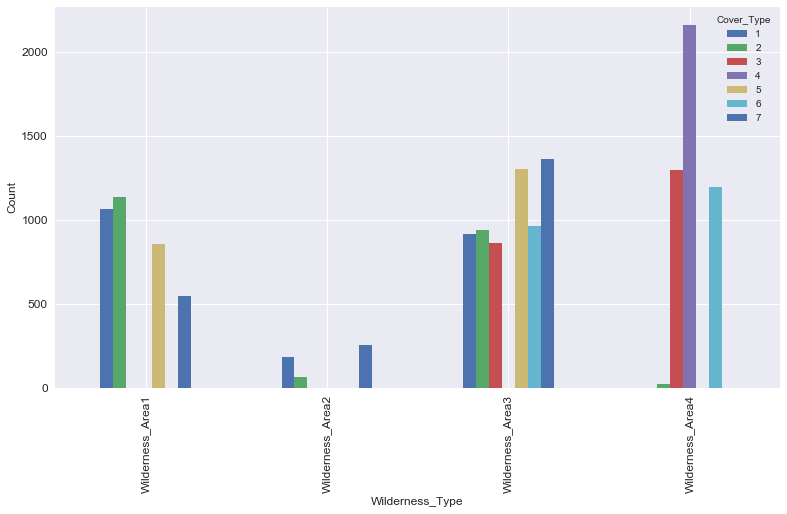

In [53]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

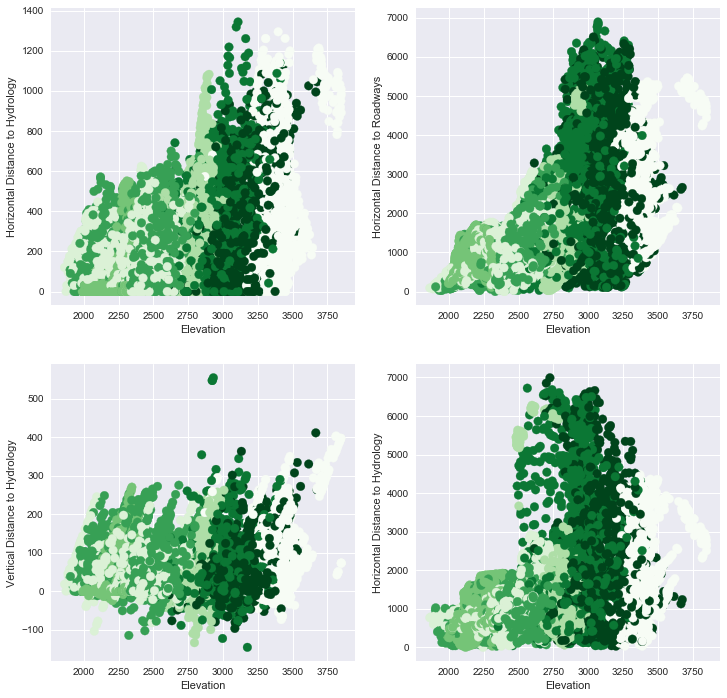

In [54]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology") 

plt.show()

Looking at this, we can see with a small adjustment to the elevation values in relation to the horizontal distance to hydrology, we can get the labels differentiated better.  We try to do this in the next figure.

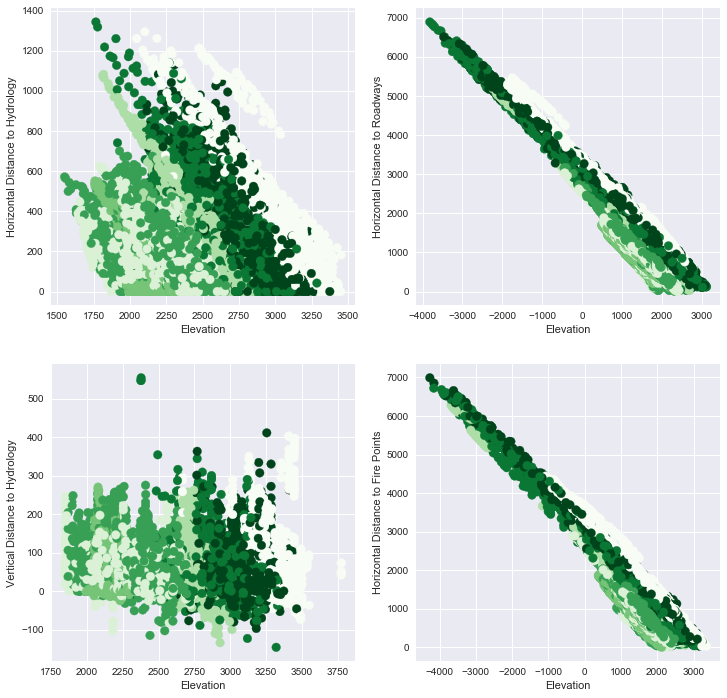

In [55]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Hydrology, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Roadways, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation - df.Vertical_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Fire_Points, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Fire Points") 

plt.show()

We can see that the cover types cluster a bit better.  We can see if adjusting this will help with the model.

# Dimensionality Reduction

We'd  like to reduce our feature space to make our modelling simpler, while hopefully preserving the variablility/information in our data.

Below we explore how much variance is explained as we increase the number of PCA components. We found that there was not a logical cut off that allowed us to both reduce the number of features, and preserve variance within the data.

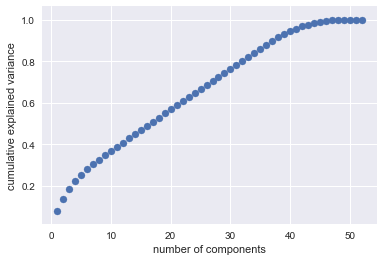

In [56]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.scatter(range(1,53),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We'd also like to see if on an extremely simplified case with only 2 PCA components if we could pick find visibly separable data.

In [57]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

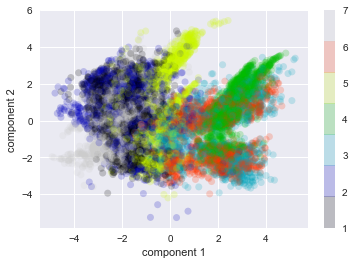

In [58]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.2,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

After additional attempts, we didn't find strong evidence that PCA was going to help us much. See the the appendix at the end of this notebook for additional trials with PCA

# Feature Selection

In [59]:
def remove_features(data, feature_list):
    new_data = data.copy(deep=True)
    new_data.drop(new_data.columns[feature_list], axis=1, inplace=True)
    return new_data

In [60]:
# baseline
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

lr_accuracy = np.mean(y_pred == y_test)
lr_accuracy

0.67715430861723447

## Stepwise selection with LogisticRegression

In [61]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

max_columns = data.shape[1]

max_accuracy = 0
bad_features = []
for i in range(0, max_columns):
    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
    lr_pipe.fit(X_train.as_matrix()[:, 0:i+1], y_train)
    y_pred = lr_pipe.predict(X_test.as_matrix()[:, 0:i+1])
    
    new_accurancy = np.mean(y_pred == y_test)
    
    if new_accurancy < max_accuracy:
        bad_features.append(i)
    
    if new_accurancy > max_accuracy:
        max_accuracy = new_accurancy
    
    print("Column {}:".format(i), new_accurancy, 'worse' if i in bad_features else '')

Column 0: 0.533266533066 
Column 1: 0.525651302605 worse
Column 2: 0.528056112224 worse
Column 3: 0.533867735471 
Column 4: 0.538276553106 
Column 5: 0.536472945892 worse
Column 6: 0.569338677355 
Column 7: 0.586973947896 
Column 8: 0.586973947896 
Column 9: 0.582765531062 worse
Column 10: 0.591783567134 
Column 11: 0.593386773547 
Column 12: 0.601002004008 
Column 13: 0.601603206413 
Column 14: 0.602004008016 
Column 15: 0.602805611222 
Column 16: 0.611422845691 
Column 17: 0.631062124248 
Column 18: 0.631863727455 
Column 19: 0.633066132265 
Column 20: 0.633066132265 
Column 21: 0.633066132265 
Column 22: 0.633266533066 
Column 23: 0.650901803607 
Column 24: 0.649899799599 worse
Column 25: 0.657314629259 
Column 26: 0.653907815631 worse
Column 27: 0.655711422846 worse
Column 28: 0.655711422846 worse
Column 29: 0.659318637275 
Column 30: 0.655310621242 worse
Column 31: 0.655911823647 worse
Column 32: 0.656913827655 worse
Column 33: 0.660320641283 
Column 34: 0.659919839679 worse
Colum

In [63]:
# New accuracy with removed features
new_data = remove_features(data, bad_features)

print(new_data.shape)

X_train, y_train, X_test, y_test = split_data(new_data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
new_accuracy

(15120, 27)


0.65050100200400807

After removing features that made the model worse the overall accuracy has gone down with the LogisticRegression compared to the same model with all the features

## Ridge Regression to choose features

In [64]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), RidgeClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)

coefs = lr_pipe.named_steps['ridgeclassifier'].coef_

indexes = np.nonzero(coefs == 0)[1]
zero_features = np.unique(indexes)

print('Columns to remove:')
for i in zero_features:
    print(data.columns[i])
    
print('Accuracy with Ridge Regression: {}'.format(new_accuracy))

Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6362725450901804


Ridge Regression finds the two soil types with no examples in the training set. Performance is worse with this classifier compared to Linear Regression.

## Random Forest Feature Selection

In [65]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(RandomForestClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
print('Random Forest accuracy: {}'.format(new_accuracy), '\n')

features = lr_pipe.named_steps['randomforestclassifier'].feature_importances_

features = sorted(zip(features, data.columns), reverse=True)
for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

Random Forest accuracy: 0.8226452905811623 

0.2245, Elevation
0.0898, Horizontal_Distance_To_Roadways
0.0733, Horizontal_Distance_To_Fire_Points
0.0709, Horizontal_Distance_To_Hydrology
0.0515, Aspect
0.0506, Hillshade_9am
0.0496, Vertical_Distance_To_Hydrology
0.0479, Hillshade_3pm
0.0469, Hillshade_Noon
0.0383, Slope
0.0270, Wilderness_Area4
0.0261, Soil_Type38
0.0213, Soil_Type3
0.0207, Wilderness_Area1
0.0181, Soil_Type39
0.0167, Soil_Type10
0.0155, Wilderness_Area3
0.0136, Soil_Type40
0.0130, Soil_Type4
0.0103, Soil_Type30
0.0078, Soil_Type13
0.0060, Soil_Type22
0.0057, Soil_Type29
0.0055, Soil_Type17
0.0053, Soil_Type23
0.0053, Soil_Type32
0.0045, Soil_Type2
0.0043, Soil_Type12
0.0043, Soil_Type33
0.0042, Soil_Type11
0.0032, Soil_Type24
0.0029, Soil_Type35
0.0023, Soil_Type6
0.0022, Soil_Type31
0.0018, Soil_Type20
0.0016, Soil_Type1
0.0013, Soil_Type5
0.0011, Wilderness_Area2
0.0010, Soil_Type18
0.0008, Soil_Type37
0.0007, Soil_Type16
0.0005, Soil_Type14
0.0005, Soil_Type19
0.00

The Random Forest Classifier finds Elevation and Horizontal distance to be the most important features. This classifier performs well and does feature selection.

# Feature Engineering

After many trials the only feature that we saw significant accuracy benefits from was adding a new variable, which took the mean of all of the horizontal distance metrics to our model. Our intuition around this metric could be simplified down to average distance to "disturbance", if we consider fires, roads, and water sources of potential "disturbance."

In [66]:
## Base Line Random Forest
def base_line_rfc(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)
    lr_pipe = make_pipeline(RandomForestClassifier())
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_rfc_accuracy = base_line_rfc(data)
base_rfc_accuracy

0.8224448897795591

In [67]:
## Base Line Logistic
def base_line_lr(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)

    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_lr_accuracy = base_line_lr(data)
base_lr_accuracy

0.67715430861723447

In [68]:
def print_base_results(new_data):
    print('Base RFC: {:.4f}, New RFC: {:.4f}'.format(base_rfc_accuracy, base_line_rfc(new_data)))
    print('Base LR:  {:.4f}, New LR:  {:.4f}'.format(base_lr_accuracy, base_line_lr(new_data)))

## Polynomial Features

In [35]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [20, 25, 30, 35]
tol = [.01]
penalty = ['l2']
degree = range(2, 3)
param_grid = {
    'polynomialfeatures__degree': degree,
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': penalty,
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

X_train, y_train, X_test, y_test = split_data(data, labels)

%time grid.fit(X_train, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
new_accuracy = np.mean(y_pred == y_test)
print('Base LR: {:.4f}, With Polynomials: {:.4f}'.format(base_lr_accuracy, new_accuracy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.5min finished


CPU times: user 2min 21s, sys: 665 ms, total: 2min 22s
Wall time: 18min 54s
Best params for Logistic Regression: {'logisticregression__C': 20, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
Base LR: 0.6772, With Polynomials: 0.7860


## Mean Disturbances Feature

In [90]:
def mean_disturb_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_disturb'] = (data.Horizontal_Distance_To_Fire_Points \
                            + data.Horizontal_Distance_To_Hydrology \
                            + data.Horizontal_Distance_To_Roadways) / 3
    return new_data

In [91]:
new_data = mean_disturb_feat(data)
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8389
Base LR:  0.6772, New LR:  0.6772


## Mean Fire Hydro Feature

In [92]:
def mean_fire_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_fire_hydro'] = (data.Horizontal_Distance_To_Fire_Points \
                            + data.Horizontal_Distance_To_Hydrology) / 2
    return new_data

In [93]:
new_data = mean_fire_hydro_feat(data)
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8329
Base LR:  0.6772, New LR:  0.6772


## Plotting Features

### New elevation feature

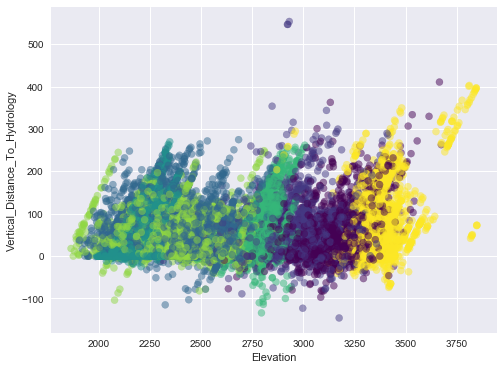

In [73]:
my_scatter(data.Elevation, data.Vertical_Distance_To_Hydrology)

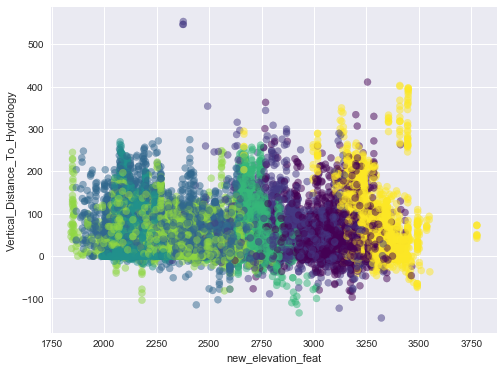

In [74]:
def new_elevation_feat(data):
    new_data = data.copy(deep=True)
    new_feature = new_data.Elevation - new_data.Vertical_Distance_To_Hydrology
    new_data['new_elevation_feat'] = new_feature
    return new_data

new_data = new_elevation_feat(data)
my_scatter(new_data.new_elevation_feat, new_data.Vertical_Distance_To_Hydrology)

In [75]:
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8329
Base LR:  0.6772, New LR:  0.6766


### New Elevation Hydro Feature

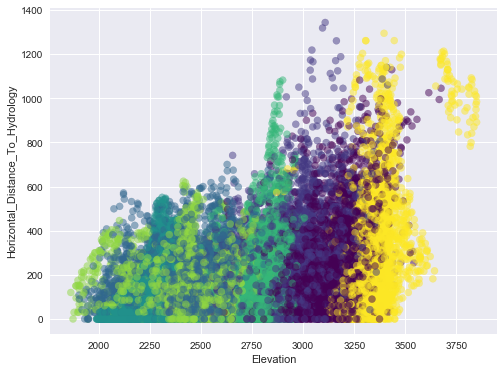

In [76]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Hydrology)

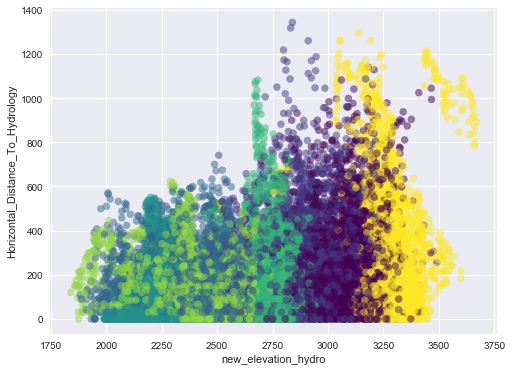

In [77]:
def new_elevation_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_hydro'] = new_data.Elevation - new_data.Horizontal_Distance_To_Hydrology * .2
    return new_data

new_data = new_elevation_hydro_feat(data)
my_scatter(new_data.new_elevation_hydro, data.Horizontal_Distance_To_Hydrology)

In [78]:
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8279
Base LR:  0.6772, New LR:  0.6764


### New Hillshade Feature

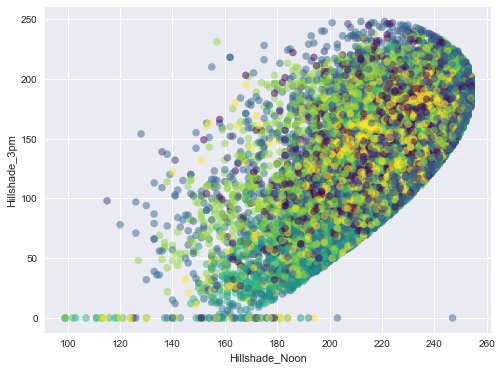

In [79]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

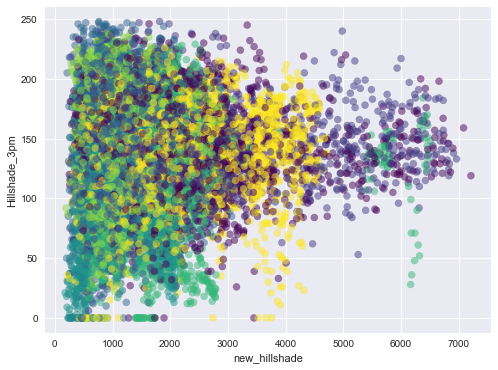

In [80]:
def new_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade'] = data.Hillshade_Noon + data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_hillshade_feat(data)
my_scatter(new_data.new_hillshade, new_data.Hillshade_3pm)

In [81]:
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8361
Base LR:  0.6772, New LR:  0.6772


### New Hillshade_Hillshade Feature

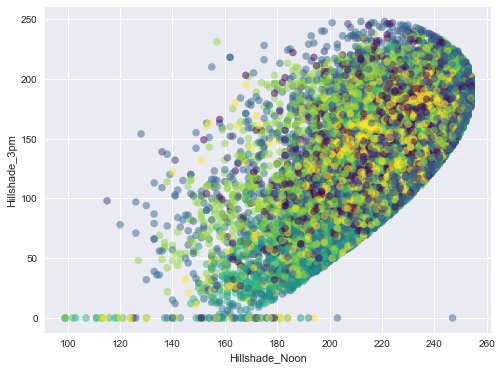

In [82]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

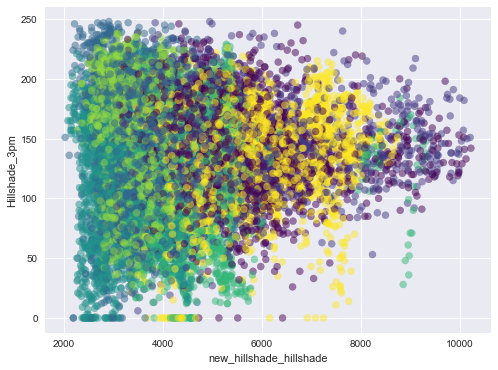

In [83]:
def new_hillshade_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade_hillshade'] = data.Hillshade_Noon - data.Aspect + \
        data.Horizontal_Distance_To_Fire_Points + data.Elevation + data.Horizontal_Distance_To_Hydrology
    return new_data

new_data = new_hillshade_hillshade_feat(data)
my_scatter(new_data.new_hillshade_hillshade, new_data.Hillshade_3pm)

In [ ]:
def new_distance_to_h

In [84]:
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8311
Base LR:  0.6772, New LR:  0.6772


In [52]:
# #Mean distance to Disturbances 
# means_train = pd.DataFrame()
# means_test = pd.DataFrame()

# means_train['Mean_Disturbances'] = (X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology + X_train.Horizontal_Distance_To_Roadways) / 3 
# means_test['Mean_Disturbances'] = (X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology + X_test.Horizontal_Distance_To_Roadways) / 3 

# means_train['Mean_Fire_Hyd']=(X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology) / 2
# means_test['Mean_Fire_Hyd']=(X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology) / 2 

# means_train.index = X_train.index
# means_test.index = X_test.index

# X_train_means = pd.concat([X_train,means_train], axis =1, join_axes=[X_train.index])
# X_test_means = pd.concat([X_test,means_test], axis=1, join_axes=[X_test.index])

# # Test on a model

# without_mean = []
# with_mean = []
# for i in range(10):
#     log = RandomForestClassifier()
#     log.fit(X_train, y_train)
#     without_mean.append(log.score(X_test, y_test))

#     log.fit(X_train_means, y_train)
#     with_mean.append(log.score(X_test_means, y_test))
# print ("Accuracy without extra mean feature is {}".format(np.mean(without_mean)))
# print ("Accuracy with extra mean feature is {}".format(np.mean(with_mean)))

We know we want to keep this feature, so we'll permanently incorporate it into our data.

In [53]:
# # Adding this feature permanently to our data 
# X_train_std = pd.DataFrame(X_train_std)
# X_test_std = pd.DataFrame(X_test_std)

In [54]:
# X_train_std.columns, X_train_std.index = X_train.columns, X_train.index
# X_test_std.columns, X_test_std.index = X_test.columns, X_test.index

In [55]:
# X_train_std = pd.concat([X_train_std,means_train], axis =1, join_axes=[X_train_std.index])
# X_test_std = pd.concat([X_test_std,means_test], axis =1, join_axes=[X_test_std.index])

In [56]:
# X_train_std.head()

In [57]:
# #Adjusting distance to hydrology and roadways 
# adj_train = pd.DataFrame()
# adj_test = pd.DataFrame()

# #Elevation adjusted by Horizontal distance to Hyrdrology 
# adj_train['Elev_to_HD_Hyd']=X_train.Elevation - X_train.Horizontal_Distance_To_Hydrology 
# adj_test['Elev_to_HD_Hyd']=X_test.Elevation - X_test.Horizontal_Distance_To_Hydrology 

# #Elevation adjusted by Horizontal distance to Roadways 
# adj_train['Elev_to_HD_Road']=X_train.Elevation - X_train.Horizontal_Distance_To_Roadways 
# adj_test['Elev_to_HD_Road']=X_test.Elevation - X_test.Horizontal_Distance_To_Roadways 

# #Elevation adjusted by Vertical distance to Roadways 
# adj_train['Elev_to_VD_Hyd']=X_train.Elevation - X_train.Vertical_Distance_To_Hydrology 
# adj_test['Elev_to_VD_Hyd']=X_test.Elevation - X_test.Vertical_Distance_To_Hydrology 

# #Elevation adjusted by Horizontal distance to Fire Points 
# adj_train['Elev_to_Fire_Points']=X_train.Elevation - X_train.Horizontal_Distance_To_Fire_Points 
# adj_test['Elev_to_Fire_Points']=X_test.Elevation - X_test.Horizontal_Distance_To_Fire_Points 

# adj_train.index = X_train.index
# adj_test.index = X_test.index

# X_train_adj = pd.concat([X_train,adj_train], axis =1, join_axes=[X_train.index])
# X_test_adj = pd.concat([X_test,adj_test], axis=1, join_axes=[X_test.index])

# # Test on a model

# without_adj = []
# with_adj = []
# for i in range(10):
#     log = RandomForestClassifier()
#     log.fit(X_train, y_train)
#     without_adj.append(log.score(X_test, y_test))

#     log.fit(X_train_adj, y_train)
#     with_adj.append(log.score(X_test_adj, y_test))
# print "Accuracy without extra adj feature is {}".format(np.mean(without_adj))
# print "Accuracy with extra adj feature is {}".format(np.mean(with_adj))


# Model Selection

For a multiple category classification problem without text data, sklearn's chat suggested that we try KNN, SVM, and ensemble methods. We'll use KNN as our baseline and then try differnt ensemble and SVM methods. After we find the best emsemble and SVM model, we will tune the parameters. 

http://scikit-learn.org/stable/tutorial/machine_learning_map/

SVM are good for high dimensional spaces and is very customizable. They have some nice theoretical guarantees that prevent overfitting and have a simple decision boundary

Ensemble methods combine predictions over several weaker estimators. They are better with multiple categories for classification, but tend to have more complicated decision boundaries and can overfit if not supervised.

In [58]:
X_train, y_train, X_test, y_test = split_data(data, labels)

# Baseline KNN model

In [73]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.68      0.65      0.66       679
   2 - Lodgepole Pine       0.69      0.57      0.62       722
   3 - Ponderosa Pine       0.76      0.70      0.73       704
4 - Cottonwood/Willow       0.86      0.95      0.90       739
            5 - Aspen       0.82      0.92      0.87       721
      6 - Douglas-fir       0.76      0.77      0.77       722
        7 - Krummholz       0.92      0.95      0.94       703

          avg / total       0.78      0.79      0.79      4990



# Ensemble methods

We will try a bunch of ensemble methods out of the box.  We'll see if averging methods such as random trees, extra trees workds better by reducing the combined variance of the estimator or if boosting methods, which reduce the bias of the combined estimator are better on our model.  

# Random Forests

In [60]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.71      0.74      0.72       679
   2 - Lodgepole Pine       0.73      0.64      0.68       722
   3 - Ponderosa Pine       0.78      0.81      0.79       704
4 - Cottonwood/Willow       0.92      0.97      0.94       739
            5 - Aspen       0.89      0.91      0.90       721
      6 - Douglas-fir       0.83      0.80      0.81       722
        7 - Krummholz       0.94      0.96      0.95       703

          avg / total       0.83      0.83      0.83      4990



# Extra Trees

In [61]:
model = ExtraTreesClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.70      0.75      0.73       679
   2 - Lodgepole Pine       0.73      0.62      0.67       722
   3 - Ponderosa Pine       0.79      0.82      0.81       704
4 - Cottonwood/Willow       0.92      0.96      0.94       739
            5 - Aspen       0.87      0.91      0.89       721
      6 - Douglas-fir       0.83      0.81      0.82       722
        7 - Krummholz       0.94      0.95      0.94       703

          avg / total       0.83      0.83      0.83      4990



# AdaBoost

In [62]:
model = AdaBoostClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.32      0.44      0.37       679
   2 - Lodgepole Pine       0.45      0.07      0.13       722
   3 - Ponderosa Pine       0.42      0.02      0.05       704
4 - Cottonwood/Willow       0.00      0.00      0.00       739
            5 - Aspen       0.40      0.84      0.54       721
      6 - Douglas-fir       0.29      0.86      0.43       722
        7 - Krummholz       0.58      0.21      0.31       703

          avg / total       0.35      0.35      0.26      4990



/Users/chrisfleisch/anaconda3/envs/w207_final/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# GradientBoosting

In [63]:
model = GradientBoostingClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.71      0.71      0.71       679
   2 - Lodgepole Pine       0.72      0.58      0.64       722
   3 - Ponderosa Pine       0.75      0.72      0.74       704
4 - Cottonwood/Willow       0.91      0.96      0.94       739
            5 - Aspen       0.80      0.89      0.84       721
      6 - Douglas-fir       0.77      0.77      0.77       722
        7 - Krummholz       0.91      0.96      0.93       703

          avg / total       0.80      0.80      0.80      4990



It looks like averaging methods worked best on our data set.  Extra trees was the best estimaor with an average prevision, recall, and recall of 86%.  This is an improvement over our KNN baseline of 80%. 

# SVM

In [96]:
svm_pipe = make_pipeline(StandardScaler(), SVC())
svm_pipe.fit (X_train, y_train)
y_pred = svm_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.63      0.68      0.65       679
   2 - Lodgepole Pine       0.65      0.56      0.60       722
   3 - Ponderosa Pine       0.68      0.61      0.64       704
4 - Cottonwood/Willow       0.79      0.96      0.86       739
            5 - Aspen       0.74      0.79      0.77       721
      6 - Douglas-fir       0.68      0.63      0.65       722
        7 - Krummholz       0.91      0.87      0.89       703

          avg / total       0.73      0.73      0.73      4990



# Parameter Tuning With New Features

In [97]:

### Add new features 
def get_new_features_data_rf(data):
    new_feature_funcs = [mean_disturb_feat, mean_fire_hydro_feat, new_elevation_feat,
                         new_elevation_hydro_feat, new_hillshade_feat,
                         new_hillshade_hillshade_feat]
    new_data = data.copy(deep=True)
    for func in new_feature_funcs:
        new_data = func(new_data)

    return new_data

new_data = get_new_features_data_rf(data)
new_data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1   
2            0        

## Random Forest

In [98]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [1000,], 
    'randomforestclassifier__criterion': ['entropy',],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__max_depth': [None, 35, 50],
    'randomforestclassifier__bootstrap': [False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.4min finished


Wall time: 5min 8s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__criterion': ['entropy'], 'randomforestclassifier__n_estimators': [1000], 'randomforestclassifier__max_features': ['sqrt'], 'randomforestclassifier__bootstrap': [False], 'randomforestclassifier__max_depth': [None, 35, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [99]:
print(grid.best_params_)
best_rfc = grid.best_estimator_
y_pred = best_rfc.predict(X_test)
print(np.mean(y_pred == y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 50}
0.88877755511
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.80      0.80      0.80       679
   2 - Lodgepole Pine       0.82      0.72      0.76       722
   3 - Ponderosa Pine       0.87      0.87      0.87       704
4 - Cottonwood/Willow       0.95      0.99      0.97       739
            5 - Aspen       0.91      0.96      0.93       721
      6 - Douglas-fir       0.89      0.91      0.90       722
        7 - Krummholz       0.96      0.98      0.97       703

          avg / total       0.89      0.89      0.89      4990



In [120]:
# Show importance of new features

features = best_rfc.named_steps['randomforestclassifier'].feature_importances_
features = sorted(zip(features, new_data.columns), reverse=True)

for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

0.1507, new_elevation_hydro
0.1425, new_elevation_feat
0.1312, Elevation
0.0484, mean_disturb
0.0476, Horizontal_Distance_To_Roadways
0.0451, new_hillshade_hillshade
0.0421, Wilderness_Area4
0.0329, Horizontal_Distance_To_Hydrology
0.0311, mean_fire_hydro
0.0294, new_hillshade
0.0287, Horizontal_Distance_To_Fire_Points
0.0273, Vertical_Distance_To_Hydrology
0.0273, Hillshade_9am
0.0250, Aspect
0.0228, Hillshade_Noon
0.0218, Hillshade_3pm
0.0208, Wilderness_Area1
0.0168, Slope
0.0162, Wilderness_Area3
0.0154, Soil_Type10
0.0100, Soil_Type3
0.0080, Soil_Type39
0.0079, Soil_Type38
0.0067, Soil_Type4
0.0047, Soil_Type30
0.0039, Soil_Type29
0.0034, Soil_Type40
0.0032, Soil_Type2
0.0029, Soil_Type17
0.0026, Soil_Type32
0.0026, Soil_Type23
0.0024, Wilderness_Area2
0.0024, Soil_Type13
0.0023, Soil_Type33
0.0021, Soil_Type22
0.0019, Soil_Type12
0.0017, Soil_Type6
0.0016, Soil_Type11
0.0010, Soil_Type24
0.0010, Soil_Type31
0.0009, Soil_Type20
0.0007, Soil_Type5
0.0007, Soil_Type1
0.0006, Soil_Ty

## Extra Trees

In [68]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(ExtraTreesClassifier())

param_grid = {
    'extratreesclassifier__n_estimators': [1000, 2000, 3000], 
    'extratreesclassifier__criterion': ['entropy', 'gini'],
    'extratreesclassifier__max_features': ['auto','sqrt', 'log2', None],
    'extratreesclassifier__max_depth': [25, 30, 35],
    'extratreesclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 94.8min finished


CPU times: user 35.1 s, sys: 5.43 s, total: 40.5 s
Wall time: 1h 35min 14s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('extratreesclassifier', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'extratreesclassifier__max_features': ['auto', 'sqrt', 'log2', None], 'extratreesclassifier__max_depth': [25, 30, 35], 'extratreesclassifier__n_estimators': [1000, 2000, 3000], 'extratreesclassifier__bootstrap': [True, False], 'extratreesclassifier__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [69]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'extratreesclassifier__max_features': 'auto', 'extratreesclassifier__max_depth': 35, 'extratreesclassifier__n_estimators': 2000, 'extratreesclassifier__bootstrap': False, 'extratreesclassifier__criterion': 'entropy'}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.81      0.79      0.80       679
   2 - Lodgepole Pine       0.82      0.73      0.77       722
   3 - Ponderosa Pine       0.88      0.86      0.87       704
4 - Cottonwood/Willow       0.93      0.98      0.95       739
            5 - Aspen       0.92      0.97      0.94       721
      6 - Douglas-fir       0.89      0.90      0.90       722
        7 - Krummholz       0.96      0.98      0.97       703

          avg / total       0.89      0.89      0.89      4990



## SVM

In [75]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)
svm_pipe = make_pipeline(StandardScaler(), SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  
    'svc__C': [50, 100, 200], 
    'svc__gamma': [.01, .05, .1]
} 
grid = GridSearchCV(svm_pipe, param_grid, cv=5, n_jobs=-1)
%time grid.fit(X_train, y_train)

CPU times: user 5.59 s, sys: 307 ms, total: 5.89 s
Wall time: 11min 5s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__C': [50, 100, 200], 'svc__kernel': ['linear', 'rbf'], 'svc__gamma': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [76]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'svc__C': 100, 'svc__kernel': 'rbf', 'svc__gamma': 0.05}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.73      0.73       679
   2 - Lodgepole Pine       0.73      0.66      0.69       722
   3 - Ponderosa Pine       0.82      0.77      0.79       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.93      0.91       721
      6 - Douglas-fir       0.83      0.85      0.84       722
        7 - Krummholz       0.94      0.97      0.95       703

          avg / total       0.84      0.84      0.84      4990



With parameter tuning, we were able to get the accuracy up to.

# Error analysis

Helper Functions

In [244]:
def create_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization'):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title=title)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

In [101]:
rfc = best_rfc.get_params()['randomforestclassifier']

In [102]:
new_data = get_new_features_data_rf(data)
X_train, y_train, X_test, y_test = split_data(new_data, labels)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(np.mean(y_pred == y_test))

0.888577154309


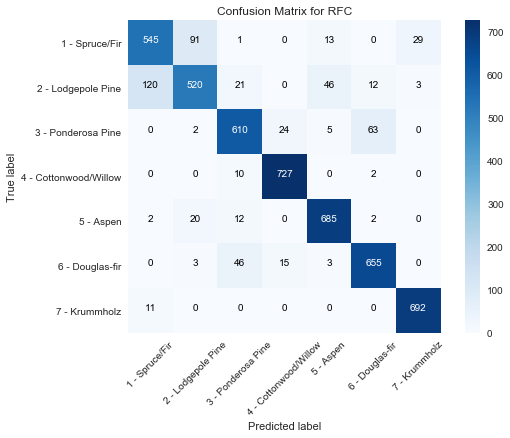

In [245]:
create_confusion_matrix(y_test, y_pred, title="Confusion Matrix for RFC")

It looks like there's some confusion concerning classes 1 & 2 as well as classes 3 & 6. Let's see if there's any data that might shed some light on why these pairs exist, and how we might get around the confusion.

In [116]:
# look at the biggest errors:
# get the probabilites for each example
probs = rfc.predict_proba(X_test)

# get the max probability for each example
max_probs = np.max(probs, axis=1)

# get the probs of the true label
true_label_probs = probs[np.arange(len(probs)), y_test-1]

r_ratio = max_probs / true_label_probs

# get the indexes for the top 3 R ratio
indexes = np.argpartition(r_ratio, -3)[-3:]

for index in indexes:
    print('\n============\n')
    print(index)
    print(X_test.iloc[index], '\n')
    print('True label:', y_test.iloc[index])
    print('Predicated label:', y_pred[index])
    print('Probability of labels: {}'.format(probs[index]))



305
Elevation                             3279.000000
Aspect                                  62.000000
Slope                                    8.000000
Horizontal_Distance_To_Hydrology        67.000000
Vertical_Distance_To_Hydrology           3.000000
Horizontal_Distance_To_Roadways       4927.000000
Hillshade_9am                          227.000000
Hillshade_Noon                         223.000000
Hillshade_3pm                          130.000000
Horizontal_Distance_To_Fire_Points     408.000000
Wilderness_Area1                         1.000000
Wilderness_Area2                         0.000000
Wilderness_Area3                         0.000000
Wilderness_Area4                         0.000000
Soil_Type1                               0.000000
Soil_Type2                               0.000000
Soil_Type3                               0.000000
Soil_Type4                               0.000000
Soil_Type5                               0.000000
Soil_Type6                               0.0

### Cover Type 1 General Errors

In [222]:
# look at errors with cover type 1 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 1) & (y_test == 1)
X_errors = X_errors[error_msk]
X_errors.head(10)

true  pred  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
2119      1     2       2900     127     11                                30   
1086      1     2       2960      84     10                                30   
9844      1     2       3082     275     11                               592   
9295      1     7       3263     143     19                               180   
1022      1     2       3049     268     18                               537   
6786      1     5       2712     213     18                                67   
9804      1     2       2819     319     25                               120   
14677     1     2       3019      44     19                               752   
11903     1     7       3309      14      7                               390   
286       1     7       3201     331      5                                 0   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
2119                               -1                             1384   
1086                                5                             3660   
9844                              166                             3258   
9295                               39                             2873   
1022                              112                             6001   
6786                               14                              918   
9804                               48                              600   
14677                             124                             1282   
11903                              81                             3900   
286                                 0                             4002   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
2119             239             232            122   
1086             234             224            121   
9844             189             243            193   
9295             243             233            110   
1022             172             244            210   
6786             201             254            183   
9804             148             208            196   
14677            221             196            103   
11903            213             225            149   
286              208             234            164   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
2119                                 2524                 0                 0   
1086                                 2579                 1                 0   
9844                                 2097                 0                 0   
9295                                 3032                 0                 0   
1022                                 1660                 1                 0   
6786                                 1922                 0                 0   
9804                                 1033                 0                 0   
14677                                1945                 0                 0   
11903                                1410                 1                 0   
286                                  3460                 1                 0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
2119                  1                 0           0           0           0   
1086                  0                 0           0           0           0   
9844                  1                 0           0           0           0   
9295                  1                 0           0           0           0   
1022                  0                 0           0           0           0   
6786                  1                 0           0           0           0   
9804                  1                 0           0           0           0   
14677                 1                 0           0           0           0   
11903                 0                 0           0           0        

In [162]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   545.000000  545.000000  545.000000                        545.000000   
mean   3156.009174  158.770642   12.820183                        277.783486   
std     129.330779  117.975340    6.622763                        224.267125   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.000000   50.000000    8.000000                        108.000000   
50%    3163.000000  123.000000   12.000000                        218.000000   
75%    3242.000000  290.000000   16.000000                        400.000000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      545.000000                       545.000000   
mean                        41.282569                      2586.554128   
std                         57.780366                      1498.572726   
min                        -81.000000                       150.000000   
25%                          3.000000                      1400.000000   
50%                         23.000000                      2388.000000   
75%                         57.000000                      3623.000000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     545.000000      545.000000     545.000000   
mean      211.781651      223.766972     144.847706   
std        24.287078       17.720637      35.359508   
min       104.000000      152.000000      25.000000   
25%       200.000000      213.000000     123.000000   
50%       216.000000      226.000000     145.000000   
75%       228.000000      236.000000     167.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          545.000000        545.000000        545.000000   
mean                          1951.212844          0.491743          0.104587   
std                           1283.670061          0.500391          0.306302   
min                             42.000000          0.000000          0.000000   
25%                            967.000000          0.000000          0.000000   
50%                           1691.000000          0.000000          0.000000   
75%                           2707.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        545.000000             545.0       545.0       545.0       545.0   
mean           0.403670               0.0         0.0         0.0         0.0   
std            0.491083               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       545.0       545.0       545.0       545.0       545.0       545.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [163]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   134.000000  134.000000  134.000000                        134.000000   
mean   3005.500000  162.014925   12.425373                        278.402985   
std     216.548689  110.409081    6.304762                        273.206692   
min    2579.000000    1.000000    2.000000                          0.000000   
25%    2855.500000   64.500000    7.250000                         67.000000   
50%    2950.500000  124.000000   12.000000                        180.000000   
75%    3153.750000  265.750000   17.000000                        446.000000   
max    3473.000000  359.000000   34.000000                       1129.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      134.000000                       134.000000   
mean                        48.305970                      2420.507463   
std                         65.168287                      1583.644382   
min                        -80.000000                       134.000000   
25%                          5.250000                      1080.500000   
50%                         22.500000                      2178.000000   
75%                         69.250000                      3526.750000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     134.000000      134.000000     134.000000   
mean      215.052239      225.283582     142.507463   
std        22.222835       17.803696      35.886778   
min       147.000000      162.000000       0.000000   
25%       204.000000      214.000000     120.250000   
50%       218.000000      227.000000     144.000000   
75%       231.000000      238.000000     168.750000   
max       254.000000      254.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          134.000000        134.000000        134.000000   
mean                          2140.373134          0.447761          0.044776   
std                           1394.274219          0.499130          0.207588   
min                            124.000000          0.000000          0.000000   
25%                           1237.750000          0.000000          0.000000   
50%                           1876.500000          0.000000          0.000000   
75%                           2585.750000          1.000000          0.000000   
max                           6993.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        134.000000             134.0       134.0       134.0       134.0   
mean           0.507463               0.0         0.0         0.0         0.0   
std            0.501820               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            1.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  134.000000       134.0       134.0       134.0       134.0  134.000000   
mean     0.029851         0.0         0.0         0.0         0.0    0.007463   
std      0.170814         0.0         0.0         0.0         0.0    0.086387   
min      0.000000         0.0         0.0         0.0         0.0    0.000000   
25%      0.000000         0.0         0.0         0.0         0.0    0.000000   
50%      0.000000         0.0         0.0         0.0         0.0    0.000000   
75%      0.000000         0.0         0.0         0.0         0.0    0.000000   
max      1.000000

We can see that the erors have a lower mean elevation. Their vertical distance is a little higher and distance to roadways is also lower.

### Cover Type 1 Predicted 2 Errors

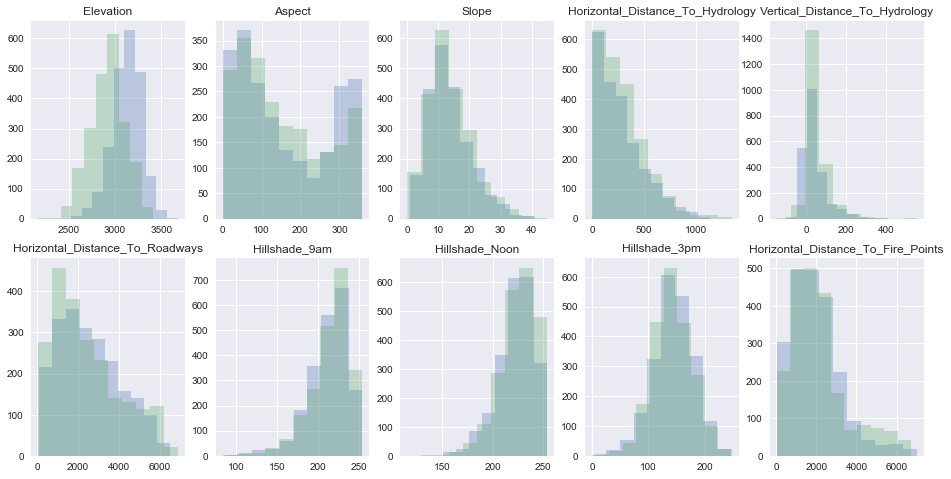

In [218]:
#Display the data between classes 1 and 2
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [1, 2]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

Well that explains a lot. These classes are nearly identical. Let's dig a bit deeper though and see look specifically at the 1s that were mistaken for 2s.

In [221]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 2) & (y_test == 1)
X_errors = X_errors[error_msk]

In [205]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   545.000000  545.000000  545.000000                        545.000000   
mean   3156.009174  158.770642   12.820183                        277.783486   
std     129.330779  117.975340    6.622763                        224.267125   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3068.000000   50.000000    8.000000                        108.000000   
50%    3163.000000  123.000000   12.000000                        218.000000   
75%    3242.000000  290.000000   16.000000                        400.000000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      545.000000                       545.000000   
mean                        41.282569                      2586.554128   
std                         57.780366                      1498.572726   
min                        -81.000000                       150.000000   
25%                          3.000000                      1400.000000   
50%                         23.000000                      2388.000000   
75%                         57.000000                      3623.000000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     545.000000      545.000000     545.000000   
mean      211.781651      223.766972     144.847706   
std        24.287078       17.720637      35.359508   
min       104.000000      152.000000      25.000000   
25%       200.000000      213.000000     123.000000   
50%       216.000000      226.000000     145.000000   
75%       228.000000      236.000000     167.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          545.000000        545.000000        545.000000   
mean                          1951.212844          0.491743          0.104587   
std                           1283.670061          0.500391          0.306302   
min                             42.000000          0.000000          0.000000   
25%                            967.000000          0.000000          0.000000   
50%                           1691.000000          0.000000          0.000000   
75%                           2707.000000          1.000000          0.000000   
max                           6632.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        545.000000             545.0       545.0       545.0       545.0   
mean           0.403670               0.0         0.0         0.0         0.0   
std            0.491083               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       545.0       545.0       545.0       545.0       545.0       545.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0

In [206]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    91.000000   91.000000  91.000000                         91.000000   
mean   2937.769231  153.780220  12.890110                        246.967033   
std     120.224150  112.467358   6.161621                        223.446113   
min    2579.000000    9.000000   2.000000                          0.000000   
25%    2861.500000   62.000000   8.000000                         67.000000   
50%    2937.000000  108.000000  12.000000                        180.000000   
75%    3004.500000  270.000000  16.500000                        366.500000   
max    3264.000000  356.000000  34.000000                        900.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       91.000000                        91.000000   
mean                        44.571429                      2592.098901   
std                         59.636518                      1736.109290   
min                        -80.000000                       134.000000   
25%                          5.500000                      1105.000000   
50%                         22.000000                      2329.000000   
75%                         63.500000                      3851.000000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      91.000000       91.000000      91.000000   
mean      215.395604      222.780220     139.362637   
std        24.115868       17.027952      38.217656   
min       147.000000      162.000000       0.000000   
25%       203.500000      214.000000     116.500000   
50%       222.000000      225.000000     135.000000   
75%       232.500000      232.500000     167.000000   
max       254.000000      253.000000     216.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           91.000000         91.000000              91.0   
mean                          2340.395604          0.549451               0.0   
std                           1549.838335          0.500305               0.0   
min                            124.000000          0.000000               0.0   
25%                           1239.500000          0.000000               0.0   
50%                           1935.000000          1.000000               0.0   
75%                           2958.000000          1.000000               0.0   
max                           6993.000000          1.000000               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         91.000000              91.0        91.0        91.0        91.0   
mean           0.450549               0.0         0.0         0.0         0.0   
std            0.500305               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count        91.0        91.0        91.0        91.0        91.0   91.000000   
mean          0.0         0.0         0.0         0.0         0.0    0.010989   
std           0.0         0.0         0.0         0.0         0.0    0.104828   
min           0.0         0.0         0.0         0.0         0.0    0.000000   
25%           0.0         0.0         0.0         0.0         0.0    0.000000   
50%           0.0         0.0         0.0         0.0         0.0    0.000000   
75%           0.0         0.0         0.0         0.0         0.0    0.000000   
max           0.0         

It appears that the mean Horizontal_Distance_To_Fire_Points was about 1.14x the distance from the accurately predicted class 1s. That really seems to be the most glaring disparity here. 

Median elevations: True: 3163.000000, Error: 2937.000000, (92.854885%)
Median distance to fire: True: 1691.000000, Error: 1935.000000, (114.429332%)


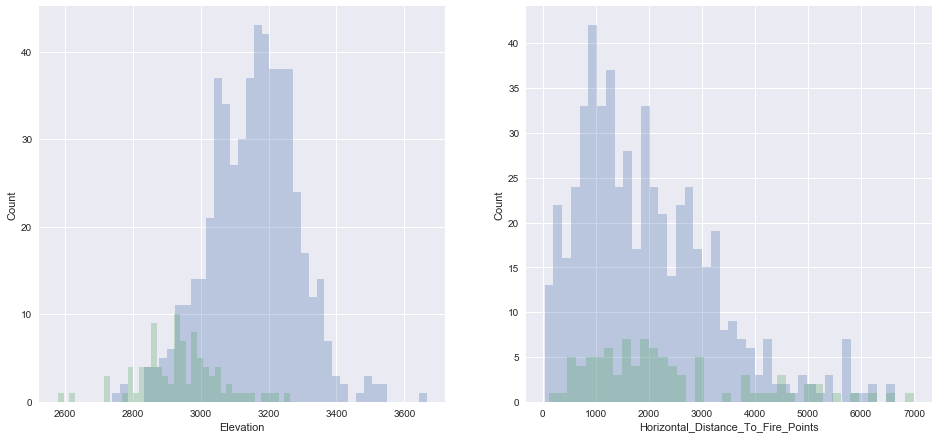

In [210]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

### Cover Type 2 Errors

In [220]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 2) & (y_test == 2)
X_errors = X_errors[error_msk]

In [157]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   520.000000  520.000000  520.000000                        520.000000   
mean   2904.571154  144.659615   13.317308                        306.619231   
std     161.468713  105.466600    6.976239                        225.935787   
min    2512.000000    0.000000    1.000000                          0.000000   
25%    2804.750000   54.000000    8.000000                        146.000000   
50%    2920.000000  123.500000   12.000000                        258.000000   
75%    3001.000000  216.000000   17.000000                        430.000000   
max    3387.000000  357.000000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      520.000000                       520.000000   
mean                        47.842308                      2413.419231   
std                         61.029527                      1590.650878   
min                        -89.000000                        95.000000   
25%                          9.000000                      1134.500000   
50%                         32.000000                      2051.000000   
75%                         69.000000                      3276.750000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     520.000000      520.000000     520.000000   
mean      214.088462      225.215385     142.880769   
std        25.352541       17.506942      33.063336   
min        95.000000      141.000000      44.000000   
25%       204.000000      214.000000     120.000000   
50%       220.000000      227.000000     141.000000   
75%       231.250000      239.000000     162.000000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          520.000000        520.000000        520.000000   
mean                          2278.492308          0.582692          0.013462   
std                           1443.820390          0.493589          0.115351   
min                             95.000000          0.000000          0.000000   
25%                           1250.500000          0.000000          0.000000   
50%                           1945.000000          1.000000          0.000000   
75%                           2713.750000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        520.000000        520.000000       520.0       520.0  520.000000   
mean           0.401923          0.001923         0.0         0.0    0.005769   
std            0.490759          0.043853         0.0         0.0    0.075809   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            0.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  520.000000       520.0  520.000000       520.0       520.0  520.000000   
mean     0.005769         0.0    0.001923         0.0         0.0    0.003846   
std      0.075809         0.0    0.043853         0.0         0.0    0.061958   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000

In [158]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   202.0000  202.000000  202.000000                        202.000000   
mean   2964.5000  154.841584   14.460396                        245.514851   
std     232.4279  105.665504    7.323439                        181.884284   
min    2353.0000    0.000000    0.000000                          0.000000   
25%    2769.2500   66.000000    9.000000                         98.250000   
50%    3036.5000  133.500000   14.000000                        212.000000   
75%    3150.5000  229.500000   19.000000                        335.000000   
max    3402.0000  358.000000   35.000000                        924.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      202.000000                       202.000000   
mean                        42.326733                      2189.232673   
std                         55.486650                      1541.441330   
min                       -146.000000                        30.000000   
25%                          6.000000                      1078.250000   
50%                         27.500000                      1740.500000   
75%                         63.500000                      3188.250000   
max                        262.000000                      5803.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     202.000000      202.000000     202.000000   
mean      216.465347      224.772277     138.539604   
std        23.858649       18.878707      37.618151   
min       142.000000      165.000000      19.000000   
25%       203.000000      215.250000     116.000000   
50%       222.000000      228.000000     137.000000   
75%       234.000000      238.000000     165.750000   
max       253.000000      254.000000     224.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          202.000000        202.000000        202.000000   
mean                          1736.000000          0.371287          0.074257   
std                           1078.542969          0.484349          0.262841   
min                             42.000000          0.000000          0.000000   
25%                           1069.000000          0.000000          0.000000   
50%                           1567.500000          0.000000          0.000000   
75%                           2242.750000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        202.000000        202.000000       202.0       202.0  202.000000   
mean           0.539604          0.014851         0.0         0.0    0.014851   
std            0.499667          0.121259         0.0         0.0    0.121259   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            1.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  202.000000       202.0  202.000000       202.0       202.0       202.0   
mean     0.044554         0.0    0.009901         0.0         0.0         0.0   
std      0.206836         0.0    0.099256         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         0.0    

### Cover Type 2 Predicted 1 Errors

In [219]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 1) & (y_test == 2)
X_errors = X_errors[error_msk]

In [213]:
# Describe the accurate predictions
true_msk = (y_pred == 2) & (y_test == 2)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   520.000000  520.000000  520.000000                        520.000000   
mean   2904.571154  144.659615   13.317308                        306.619231   
std     161.468713  105.466600    6.976239                        225.935787   
min    2512.000000    0.000000    1.000000                          0.000000   
25%    2804.750000   54.000000    8.000000                        146.000000   
50%    2920.000000  123.500000   12.000000                        258.000000   
75%    3001.000000  216.000000   17.000000                        430.000000   
max    3387.000000  357.000000   40.000000                       1127.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      520.000000                       520.000000   
mean                        47.842308                      2413.419231   
std                         61.029527                      1590.650878   
min                        -89.000000                        95.000000   
25%                          9.000000                      1134.500000   
50%                         32.000000                      2051.000000   
75%                         69.000000                      3276.750000   
max                        554.000000                      6890.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     520.000000      520.000000     520.000000   
mean      214.088462      225.215385     142.880769   
std        25.352541       17.506942      33.063336   
min        95.000000      141.000000      44.000000   
25%       204.000000      214.000000     120.000000   
50%       220.000000      227.000000     141.000000   
75%       231.250000      239.000000     162.000000   
max       253.000000      254.000000     248.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          520.000000        520.000000        520.000000   
mean                          2278.492308          0.582692          0.013462   
std                           1443.820390          0.493589          0.115351   
min                             95.000000          0.000000          0.000000   
25%                           1250.500000          0.000000          0.000000   
50%                           1945.000000          1.000000          0.000000   
75%                           2713.750000          1.000000          0.000000   
max                           6723.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        520.000000        520.000000       520.0       520.0  520.000000   
mean           0.401923          0.001923         0.0         0.0    0.005769   
std            0.490759          0.043853         0.0         0.0    0.075809   
min            0.000000          0.000000         0.0         0.0    0.000000   
25%            0.000000          0.000000         0.0         0.0    0.000000   
50%            0.000000          0.000000         0.0         0.0    0.000000   
75%            1.000000          0.000000         0.0         0.0    0.000000   
max            1.000000          1.000000         0.0         0.0    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  520.000000       520.0  520.000000       520.0       520.0  520.000000   
mean     0.005769         0.0    0.001923         0.0         0.0    0.003846   
std      0.075809         0.0    0.043853         0.0         0.0    0.061958   
min      0.000000         0.0    0.000000         0.0         0.0    0.000000   
25%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
50%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
75%      0.000000         0.0    0.000000         0.0         0.0    0.000000   
max      1.000000

In [214]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation     Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   120.000000  120.00000  120.000000                        120.000000   
mean   3121.633333  159.97500   13.466667                        259.766667   
std     105.741633  106.38889    6.374758                        190.028513   
min    2785.000000    2.00000    1.000000                          0.000000   
25%    3050.000000   74.50000    9.000000                        120.000000   
50%    3121.000000  130.00000   12.000000                        223.000000   
75%    3193.250000  240.50000   17.000000                        367.250000   
max    3402.000000  358.00000   34.000000                        924.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      120.000000                       120.000000   
mean                        35.866667                      2729.358333   
std                         52.719160                      1657.830509   
min                       -146.000000                       108.000000   
25%                          3.000000                      1232.250000   
50%                         24.000000                      2478.000000   
75%                         52.250000                      3914.000000   
max                        262.000000                      5803.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     120.000000      120.000000     120.000000   
mean      217.241667      225.375000     139.316667   
std        23.963907       17.347686      34.690222   
min       150.000000      165.000000      60.000000   
25%       204.500000      217.000000     116.000000   
50%       223.500000      227.000000     135.500000   
75%       235.000000      237.000000     167.250000   
max       251.000000      254.000000     220.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          120.000000        120.000000        120.000000   
mean                          1882.166667          0.500000          0.116667   
std                           1215.966534          0.502096          0.322369   
min                             42.000000          0.000000          0.000000   
25%                           1134.000000          0.000000          0.000000   
50%                           1752.500000          0.500000          0.000000   
75%                           2335.000000          1.000000          0.000000   
max                           6368.000000          1.000000          1.000000   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        120.000000             120.0       120.0       120.0       120.0   
mean           0.383333               0.0         0.0         0.0         0.0   
std            0.488237               0.0         0.0         0.0         0.0   
min            0.000000               0.0         0.0         0.0         0.0   
25%            0.000000               0.0         0.0         0.0         0.0   
50%            0.000000               0.0         0.0         0.0         0.0   
75%            1.000000               0.0         0.0         0.0         0.0   
max            1.000000               0.0         0.0         0.0         0.0   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count       120.0       120.0       120.0       120.0       120.0       120.0   
mean          0.0         0.0         0.0         0.0         0.0         0.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           0.0         0.0         0.0         0.0         0.0         0.0   
75%           0.0         0.0         0.0         0.0         0.0         0.0   
max           0.0         

Median elevations: True: 2920.000000, Error: 3121.000000, (106.883562%)
Median distance to fire: True: 1945.000000, Error: 1752.500000, (90.102828%)


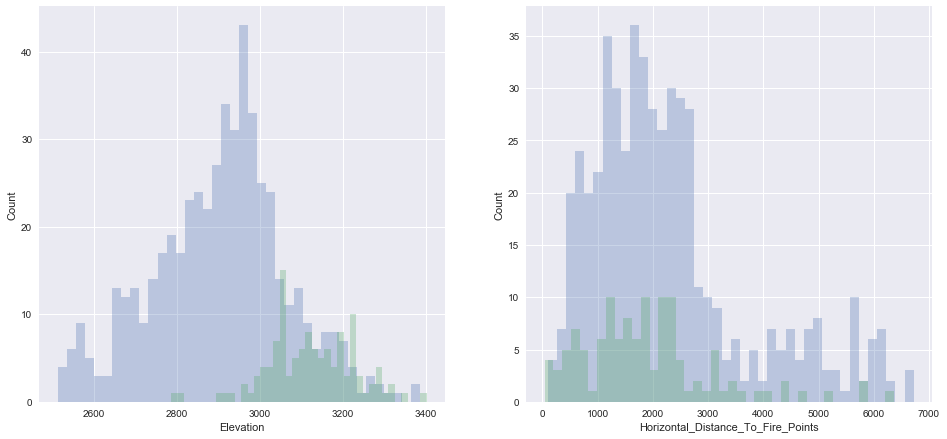

In [215]:
plt.figure(figsize=(16,16)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median elevations: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Elevation), np.median(X_errors.Elevation), (np.median(X_errors.Elevation)/ np.median(X_true.Elevation) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Elevation") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")
plt.show()

We see that this relationship between 1 & 2 with respect to fire is reciprocal in that the numbers are roughly flipped now that we're looking at 2s that were thought to be 1s.

### Cover Type 3 and 6 Errors

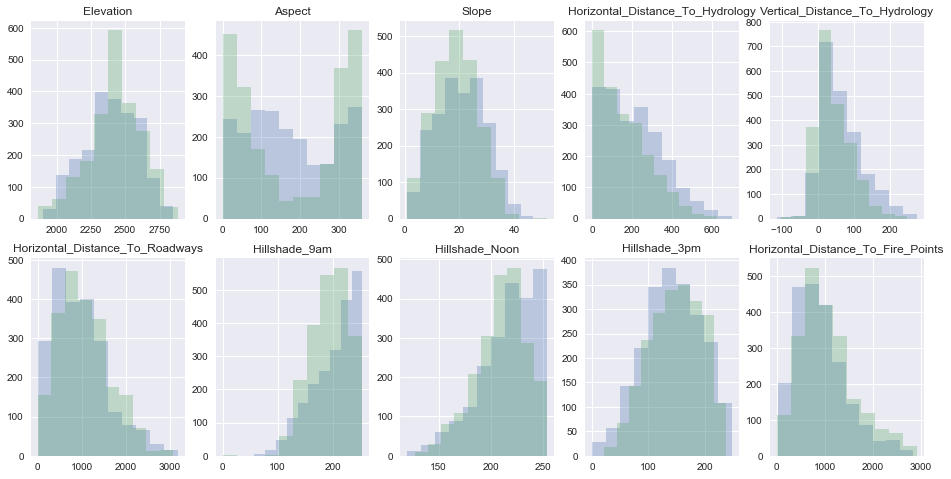

In [227]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

These aren't terribly better than 1 & 2. Let's dive deeper and see if anything stands out.

### Cover Type 3 Errors

In [228]:
# look at errors with cover type 2 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 3) & (y_test == 3)
X_errors = X_errors[error_msk]

In [229]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   610.000000  610.000000  610.000000                        610.000000   
mean   2391.132787  170.296721   21.111475                        213.470492   
std     196.141525  104.205913    8.937148                        138.921059   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2268.000000   90.000000   14.000000                         95.000000   
50%    2407.500000  152.500000   21.000000                        190.000000   
75%    2547.000000  259.500000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      610.000000                       610.000000   
mean                        65.701639                       941.078689   
std                         58.805511                       621.934978   
min                       -115.000000                        30.000000   
25%                         23.000000                       443.000000   
50%                         53.500000                       875.500000   
75%                         96.000000                      1300.000000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     610.000000      610.000000     610.000000   
mean      203.488525      216.106557     138.419672   
std        41.403545       28.373942      52.156147   
min        65.000000      133.000000       0.000000   
25%       172.250000      200.000000     102.000000   
50%       217.500000      222.000000     136.000000   
75%       237.000000      238.000000     177.750000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          610.000000             610.0             610.0   
mean                           906.578689               0.0               0.0   
std                            543.836274               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            495.000000               0.0               0.0   
50%                            831.000000               0.0               0.0   
75%                           1187.000000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        610.000000        610.000000  610.000000  610.000000  610.000000   
mean           0.393443          0.606557    0.065574    0.124590    0.059016   
std            0.488915          0.488915    0.247739    0.330525    0.235849   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  610.000000  610.000000  610.000000       610.0       610.0       610.0   
mean     0.249180    0.027869    0.109836         0.0         0.0         0.0   
std      0.432893    0.164732    0.312942         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [230]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    94.000000   94.000000  94.000000                         94.000000   
mean   2375.617021  174.787234  16.957447                        130.340426   
std     216.602063  121.554879   8.009289                        123.471868   
min    1931.000000    2.000000   1.000000                          0.000000   
25%    2221.250000   59.000000  10.250000                         30.000000   
50%    2389.000000  157.000000  16.500000                         95.000000   
75%    2535.750000  297.750000  22.000000                        177.500000   
max    2806.000000  359.000000  37.000000                        474.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       94.000000                        94.000000   
mean                        29.255319                      1043.265957   
std                         40.163894                       574.416584   
min                        -30.000000                        30.000000   
25%                          3.250000                       562.750000   
50%                         14.000000                      1099.000000   
75%                         40.000000                      1403.250000   
max                        196.000000                      2841.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      94.000000       94.000000      94.000000   
mean      204.170213      217.074468     140.989362   
std        31.152638       23.079684      47.367130   
min       118.000000      162.000000       0.000000   
25%       186.250000      198.500000     105.250000   
50%       210.000000      217.500000     146.500000   
75%       227.500000      235.750000     178.750000   
max       253.000000      254.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           94.000000              94.0              94.0   
mean                           974.787234               0.0               0.0   
std                            504.772830               0.0               0.0   
min                            120.000000               0.0               0.0   
25%                            621.250000               0.0               0.0   
50%                            937.000000               0.0               0.0   
75%                           1215.500000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         94.000000         94.000000   94.000000   94.000000    94.00000   
mean           0.382979          0.617021    0.074468    0.074468     0.06383   
std            0.488720          0.488720    0.263939    0.263939     0.24576   
min            0.000000          0.000000    0.000000    0.000000     0.00000   
25%            0.000000          0.000000    0.000000    0.000000     0.00000   
50%            0.000000          1.000000    0.000000    0.000000     0.00000   
75%            1.000000          1.000000    0.000000    0.000000     0.00000   
max            1.000000          1.000000    1.000000    1.000000     1.00000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   94.000000        94.0   94.000000        94.0        94.0        94.0   
mean     0.042553         0.0    0.117021         0.0         0.0         0.0   
std      0.202930         0.0    0.323169         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         

### Cover Type 3 Predicted 6 Errors

In [231]:
# look at errors with cover type 1 where the prediction was class 2
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred == 6) & (y_test == 3)
X_errors = X_errors[error_msk]

In [232]:
# Describe the accurate predictions
true_msk = (y_pred == 3) & (y_test == 3)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   610.000000  610.000000  610.000000                        610.000000   
mean   2391.132787  170.296721   21.111475                        213.470492   
std     196.141525  104.205913    8.937148                        138.921059   
min    1905.000000    0.000000    1.000000                          0.000000   
25%    2268.000000   90.000000   14.000000                         95.000000   
50%    2407.500000  152.500000   21.000000                        190.000000   
75%    2547.000000  259.500000   28.000000                        301.000000   
max    2823.000000  360.000000   44.000000                        700.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      610.000000                       610.000000   
mean                        65.701639                       941.078689   
std                         58.805511                       621.934978   
min                       -115.000000                        30.000000   
25%                         23.000000                       443.000000   
50%                         53.500000                       875.500000   
75%                         96.000000                      1300.000000   
max                        275.000000                      3164.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     610.000000      610.000000     610.000000   
mean      203.488525      216.106557     138.419672   
std        41.403545       28.373942      52.156147   
min        65.000000      133.000000       0.000000   
25%       172.250000      200.000000     102.000000   
50%       217.500000      222.000000     136.000000   
75%       237.000000      238.000000     177.750000   
max       254.000000      254.000000     247.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                          610.000000             610.0             610.0   
mean                           906.578689               0.0               0.0   
std                            543.836274               0.0               0.0   
min                             30.000000               0.0               0.0   
25%                            495.000000               0.0               0.0   
50%                            831.000000               0.0               0.0   
75%                           1187.000000               0.0               0.0   
max                           2846.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count        610.000000        610.000000  610.000000  610.000000  610.000000   
mean           0.393443          0.606557    0.065574    0.124590    0.059016   
std            0.488915          0.488915    0.247739    0.330525    0.235849   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count  610.000000  610.000000  610.000000       610.0       610.0       610.0   
mean     0.249180    0.027869    0.109836         0.0         0.0         0.0   
std      0.432893    0.164732    0.312942         0.0         0.0         0.0   
min      0.000000    0.000000    0.000000         0.0         0.0         0.0   
25%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
50%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
75%      0.000000    0.000000    0.000000         0.0         0.0         0.0   
max      1.000000

In [233]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count    63.000000   63.000000  63.000000                         63.000000   
mean   2418.031746  176.984127  16.952381                        143.698413   
std     169.830273  129.504327   7.915743                        113.029490   
min    2045.000000    2.000000   1.000000                          0.000000   
25%    2327.500000   45.500000  10.000000                         60.000000   
50%    2424.000000  180.000000  16.000000                        124.000000   
75%    2545.000000  310.000000  23.000000                        176.000000   
max    2696.000000  359.000000  35.000000                        450.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       63.000000                        63.000000   
mean                        32.968254                      1053.619048   
std                         40.297670                       525.818515   
min                        -30.000000                       134.000000   
25%                          8.500000                       591.500000   
50%                         23.000000                      1114.000000   
75%                         42.500000                      1355.500000   
max                        196.000000                      2197.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count      63.000000       63.000000      63.000000   
mean      196.317460      214.777778     151.095238   
std        30.261668       23.842524      38.304263   
min       118.000000      162.000000      76.000000   
25%       183.500000      193.500000     125.000000   
50%       196.000000      215.000000     152.000000   
75%       219.500000      235.000000     182.500000   
max       246.000000      252.000000     215.000000   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
count                           63.000000              63.0              63.0   
mean                          1068.634921               0.0               0.0   
std                            460.251625               0.0               0.0   
min                            350.000000               0.0               0.0   
25%                            729.000000               0.0               0.0   
50%                           1020.000000               0.0               0.0   
75%                           1258.000000               0.0               0.0   
max                           2525.000000               0.0               0.0   

       Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
count         63.000000         63.000000   63.000000   63.000000   63.000000   
mean           0.460317          0.539683    0.031746    0.063492    0.031746   
std            0.502426          0.502426    0.176731    0.245805    0.176731   
min            0.000000          0.000000    0.000000    0.000000    0.000000   
25%            0.000000          0.000000    0.000000    0.000000    0.000000   
50%            0.000000          1.000000    0.000000    0.000000    0.000000   
75%            1.000000          1.000000    0.000000    0.000000    0.000000   
max            1.000000          1.000000    1.000000    1.000000    1.000000   

       Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
count   63.000000        63.0   63.000000        63.0        63.0        63.0   
mean     0.031746         0.0    0.095238         0.0         0.0         0.0   
std      0.176731         0.0    0.295901         0.0         0.0         0.0   
min      0.000000         0.0    0.000000         0.0         0.0         0.0   
25%      0.000000         0.0    0.000000         0.0         0.0         0.0   
50%      0.000000         0.0    0.000000         0.0         0.0         0.0   
75%      0.000000         0.0    0.000000         0.0         0.0         0.0   
max      1.000000         

Median slope: True: 21.000000, Error: 16.000000, (76.190476%)
Median distance to fire: True: 831.000000, Error: 1020.000000, (122.743682%)
Median horizontal_hydro: True: 190.000000, Error: 124.000000, (65.263158%)


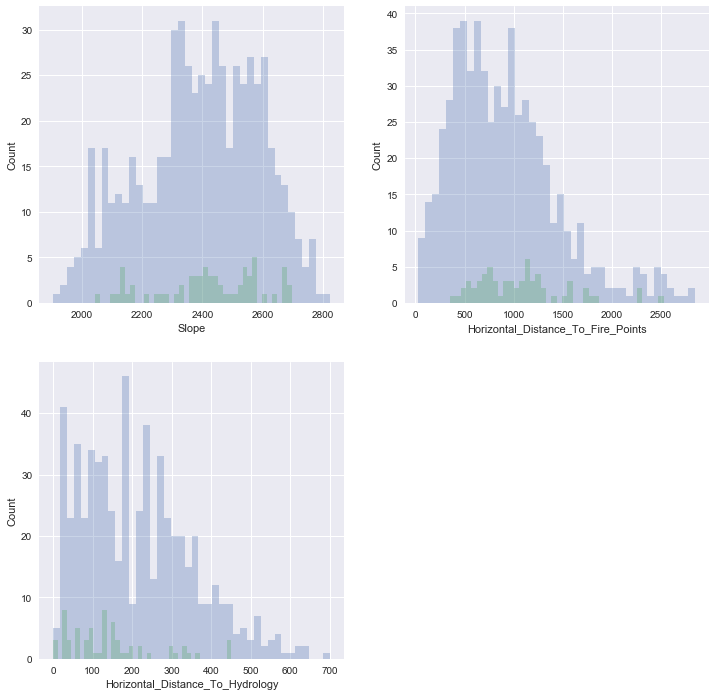

In [243]:
plt.figure(figsize=(12,12)) 

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
print("Median slope: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Slope), np.median(X_errors.Slope), (np.median(X_errors.Slope)/ np.median(X_true.Slope) * 100)))
print("Median distance to fire: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Fire_Points), np.median(X_errors.Horizontal_Distance_To_Fire_Points), (np.median(X_errors.Horizontal_Distance_To_Fire_Points) / np.median(X_true.Horizontal_Distance_To_Fire_Points) * 100)))
print("Median horizontal_hydro: True: %f, Error: %f, (%f%%)" % (np.median(X_true.Horizontal_Distance_To_Hydrology), np.median(X_errors.Horizontal_Distance_To_Hydrology), (np.median(X_errors.Horizontal_Distance_To_Hydrology)/ np.median(X_true.Horizontal_Distance_To_Hydrology) * 100)))

plt.subplot(221)
plt.hist(X_true.Elevation, **kwargs)
plt.hist(X_errors.Elevation, **kwargs);
plt.xlabel("Slope") 
plt.ylabel("Count")

plt.subplot(222)
plt.hist(X_true.Horizontal_Distance_To_Fire_Points, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Fire_Points, **kwargs);
plt.xlabel("Horizontal_Distance_To_Fire_Points") 
plt.ylabel("Count")

plt.subplot(223)
plt.hist(X_true.Horizontal_Distance_To_Hydrology, **kwargs)
plt.hist(X_errors.Horizontal_Distance_To_Hydrology, **kwargs);
plt.xlabel("Horizontal_Distance_To_Hydrology") 
plt.ylabel("Count")
plt.show()

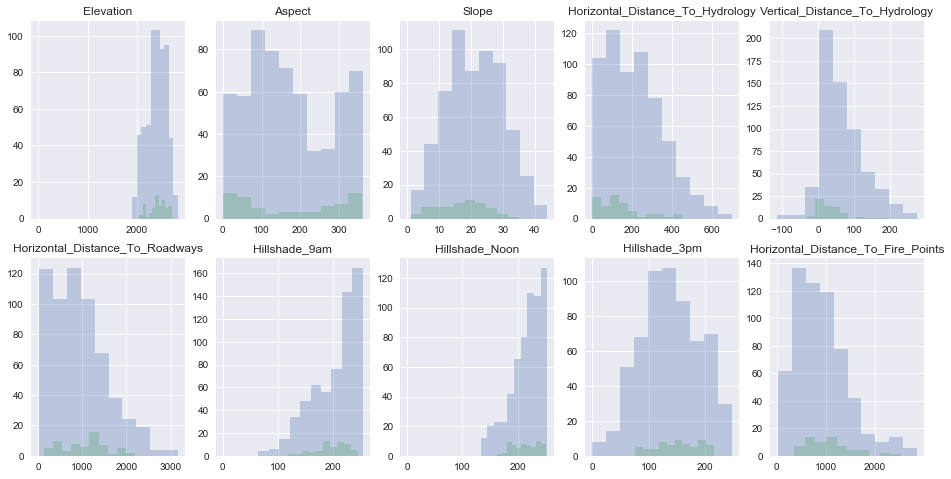

In [240]:
#Display the data between classes 3 and 6
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in [3, 6]:
        axi.hist(X_true.ix[labels==label, i], **kwargs)
        axi.hist(X_errors.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

This error certainly seems to have more noticeable differences between the correctly chosen answers and the wrong ones; however with such a relatively small group of errors, it's hard to make any conclusive statements about it.

# Test results

In [83]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...       Soil_Type31  \
0            196             214            156     ...                 0   
1            201             216            152     ...                 0   
2            206             208            137     ...                 0   
3            208             201            125     ...                 0   
4            210             195            115     ...                 0   

   Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  

[5 rows x 55 columns]

In [102]:
# ### Add new features to test data and training data
new_train = get_new_features_data_rf(data)
new_test_df = get_new_features_data_rf(test_df)
new_test_df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm           ...             \
0            196             214            156           ...              
1            201             216            152           ...              
2            206             208            137           ...              
3            208             201            125           ...              
4            210             195            115           ...              

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  mean_disturb  \
0            0            0            0            0   3109.666667   
1            0            0            0            0   3109.666667   
2            0            0            0            0   3108.000000   
3            0            0            0            0   3108.000000   
4            0            0            0            0   3108.000000   

   mean_fire_hydro  new_elevation_feat  new_elevation_hydro  new_hillshade  \
0           3322.5                2680               2680.0           6859   
1           3337.5                2683               2683.0           6891   
2           3172.0                2713               2713.0           6552   
3           3187.0                2709               2709.0           6575   
4           3202.0                2706               2706.0           6599   

   new_hillshade_hillshade  
0                     9185  
1                     9574  
2                     9249  
3                     9260  
4                     9276  

[5 rows x 61 columns]

In [104]:
rfc = best_rfc.get_params()['randomforestclassifier']
rfc.fit(new_train, labels)

new_test_df['Cover_Type'] = pd.Series(rfc.predict(new_test_df.drop(['Id'], axis=1)))

submission = pd.concat([new_test_df['Id'].astype(int), new_test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('submission.csv')
submission.head()

Cover_Type
Id               
15121           1
15122           1
15123           1
15124           1
15125           1

Results from Kaggle: 0.80025

## Problems with Test Data

In [105]:
# We see that Soil_Type7 and Soil_Type15 have values which were not present in our training set
test_df.drop(['Id'], axis=1).describe()

Elevation         Aspect          Slope  \
count  565892.000000  565892.000000  565892.000000   
mean     2964.977407     155.629558      14.039635   
std       273.157030     111.962120       7.450155   
min      1859.000000       0.000000       0.000000   
25%      2818.000000      58.000000       9.000000   
50%      2999.000000     127.000000      13.000000   
75%      3164.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     565892.000000                   565892.000000   
mean                         270.556622                       46.294408   
std                          212.500153                       58.209469   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          228.000000                       29.000000   
75%                          390.000000                       69.000000   
max                         1397.000000                      601.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    565892.000000  565892.000000   565892.000000   
mean                       2367.143116     212.131133      223.435026   
std                        1561.482002      26.661063       19.668053   
min                           0.000000       0.000000        0.000000   
25%                        1116.000000     198.000000      213.000000   
50%                        2018.000000     218.000000      226.000000   
75%                        3349.000000     231.000000      237.000000   
max                        7117.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points      ...        \
count  565892.000000                       565892.000000      ...         
mean      142.726951                         1992.826227      ...         
std        38.030094                         1327.396895      ...         
min         0.000000                            0.000000      ...         
25%       119.000000                         1034.000000      ...         
50%       143.000000                         1723.000000      ...         
75%       168.000000                         2561.000000      ...         
max       254.000000                         7173.000000      ...         

         Soil_Type31    Soil_Type32    Soil_Type33    Soil_Type34  \
count  565892.000000  565892.000000  565892.000000  565892.000000   
mean        0.044768       0.091588       0.078704       0.002808   
std         0.206795       0.288444       0.269277       0.052916   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type35    Soil_Type36    Soil_Type37    Soil_Type38  \
count  565892.000000  565892.000000  565892.000000  565892.000000   
mean        0.003161       0.000193       0.000467       0.026233   
std         0.056137       0.013877       0.021594       0.159827   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type39    Soil_Type40  
count  565892.000000  565892.000000  
mean        0.023236       0.014651  
std         0.150652       0.120152  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75% 

In [106]:
data.describe()

Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       79.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1714.023214     212.704299      218.965608   
std                        1325.066358      30.561287       22.801966   
min                           0.000000       0.000000       99.000000   
25%                         764.000000     196.000000      207.000000   
50%                        1316.000000     220.000000      223.000000   
75%                        2270.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points      ...       \
count   15120.000000                        15120.000000      ...        
mean      135.091997                         1511.147288      ...        
std        45.895189                         1099.936493      ...        
min         0.000000                            0.000000      ...        
25%       106.000000                          730.000000      ...        
50%       138.000000                         1256.000000      ...        
75%       167.000000                         1988.250000      ...        
max       248.000000                         6993.000000      ...        

        Soil_Type31   Soil_Type32   Soil_Type33   Soil_Type34   Soil_Type35  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.021958      0.045635      0.040741      0.001455      0.006746   
std        0.146550      0.208699      0.197696      0.038118      0.081859   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type36   Soil_Type37   Soil_Type38   Soil_Type39   Soil_Type40  
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000  
mean       0.000661      0.002249      0.048148      0.043452      0.030357  
std        0.025710      0.047368      0.214086      0.203880      0.171574  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000  

[8 rows x 54 columns]

# Appendix
a. There being so many soil types, we thought that it might be advantageous to utilze PCA to reduce the variables needed.

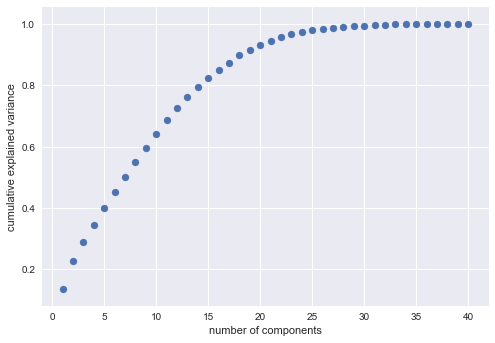

In [88]:
# Separate soil data from X_train

X_train_less_soil = X_train.drop([i for i in X_train.columns if "Soil_Type" in i],axis=1)
X_test_less_soil = X_test.drop([i for i in X_test.columns if "Soil_Type" in i],axis=1)

soil_train = X_train[[i for i in X_train.columns if "Soil_Type" in i]]
soil_test = X_test[[i for i in X_test.columns if "Soil_Type" in i]]

pca = PCA(n_components=40)
pca.fit(soil_train)
plt.scatter(range(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**We see that with only 15 components that we preserve about 80% of the variation.**

In [89]:
# Fit PCA and transform train and test data
p = PCA(n_components=15)
pca_soil_train = p.fit_transform(soil_train)
pca_soil_test = p.transform(soil_test)

# Convert back to Dataframes
pca_soil_train = pd.DataFrame(pca_soil_train)
pca_soil_test = pd.DataFrame(pca_soil_test)

# Make sure they're still on same index
pca_soil_train.index = soil_train.index
pca_soil_test.index = soil_test.index

# Put data back together
soil_pca_X_train = pd.concat([X_train_less_soil,pca_soil_train],axis=1,join_axes=[X_train_less_soil.index])
soil_pca_X_test = pd.concat([X_test_less_soil,pca_soil_test],axis=1,join_axes=[X_test_less_soil.index])

RF = RandomForestClassifier()

RF.fit(X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(X_test, y_test)))

RF.fit(soil_pca_X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(soil_pca_X_test, y_test)))

The accuracy score before PCA reduction was: 0.8476953907815631
The accuracy score before PCA reduction was: 0.8585170340681363


A feature that we thought would be helpful to engineer would be the  slope of the elevation based on the elevation and the horizontal distance to hydrology.  However, by engineering this feature, we didn't see much improvement and therefore this feature was discarded.

In [107]:
#Adjusting distance to hydrology and roadways 
slope_train = pd.DataFrame()
slope_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
slope_train['slope_hyd'] = np.sqrt(X_train.Vertical_Distance_To_Hydrology**2 + X_train.Horizontal_Distance_To_Hydrology**2) 
slope_train.slope_hyd=slope_train.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_train['slope_hyd_pct'] = X_train.Vertical_Distance_To_Hydrology / X_train.Horizontal_Distance_To_Hydrology
slope_train.slope_hyd_pct=slope_train.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_test['slope_hyd'] = np.sqrt(X_test.Vertical_Distance_To_Hydrology**2 + X_test.Horizontal_Distance_To_Hydrology**2) 
slope_test.slope_hyd=slope_test.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_test['slope_hyd_pct'] = X_test.Vertical_Distance_To_Hydrology / X_test.Horizontal_Distance_To_Hydrology
slope_test.slope_hyd_pct=slope_test.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_train.index = X_train.index
slope_test.index = X_test.index

X_train_slope = pd.concat([X_train,slope_train], axis =1, join_axes=[X_train.index])
X_test_slope = pd.concat([X_test,slope_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_slope = []
with_slope = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_slope.append(log.score(X_test, y_test))

    log.fit(X_train_slope, y_train)
    with_slope.append(log.score(X_test_slope, y_test))
print ("Accuracy without extra slope feature is {}".format(np.mean(without_slope)))
print ("Accuracy with extra slope feature is {}".format(np.mean(with_slope)))

Accuracy without extra slope feature is 0.8497194388777555
Accuracy with extra slope feature is 0.847434869739479


## Features that didn't work

### Binning hillshade_9am

In [108]:
def bin_hillshade_9am_feat(data):
    new_data = data.copy(deep=True)

    noon_bins = np.linspace(0, 255, 8)
    which_bin = np.digitize(new_data.Hillshade_9am, bins=noon_bins)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(which_bin.reshape(-1, 1))
    X_noon_binned = pd.DataFrame(encoder.transform(which_bin.reshape(-1, 1)))

    new_data = pd.concat([new_data, X_noon_binned], axis=1)

    return new_data

In [109]:
new_data = bin_hillshade_9am_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8244
Base LR:  0.6772, New LR:  0.6772


### Euclidean Distance to Hydrology

In [147]:
def new_euclidean_hydro(data):
    new_data = data.copy(deep=True)
    new_feature = (new_data.Horizontal_Distance_To_Hydrology**2 + new_data.Vertical_Distance_To_Hydrology**2) ** (1/2)
    new_data['new_euclidean_hydro'] = new_feature
    return new_data

new_data = new_euclidean_hydro(data)
print_base_results(new_data)

Base RFC: 0.8224, New RFC: 0.8188
Base LR:  0.6772, New LR:  0.6770


## Convert aspect to cardinal direction (north, south, east, west)

In [110]:
def convert_to_cardinal_feat(data):
    new_data = data.copy(deep=True)
    dir_labels = ['north east', 'east north', 'east south', 'south east', 
              'south west', 'west south', 'west north', 'north west']
    new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

    new_data.direction = new_data.direction.replace('east north', 'north') \
        .replace('north west', 'north') \
        .replace('east north', 'east').replace('east south', 'east').replace('south east', 'south') \
        .replace('south west', 'south').replace('west south', 'west').replace('west north', 'west') \
        .replace('north east', 'north')

    new_data = pd.get_dummies(new_data)
    return new_data

In [111]:
new_data = convert_to_cardinal_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8108
Base LR:  0.6772, New LR:  0.6794
